<a href="https://colab.research.google.com/github/laume/PetAdoption/blob/master/PetAdoption_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

### PetFinder.my Adoption Prediction

How cute is that doggy in the shelter?

https://www.kaggle.com/c/petfinder-adoption-prediction/data

## Prepare environment

### Setup Kaggle variables:

In [0]:
KAGGLE = True
DOWNLOAD_DATA = True
COMPETITION = 'kaggle competitions download -c petfinder-adoption-prediction'
DATA_DIR = 'data/pet'
UNARCHIVE_DATA = True

Make sure you have kaggle.json file in your working directory before starting work with kaggle. If the file is not present, doawnload it with the following command.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
TEMP_DIR = 'gdrive/My Drive/pets/'

### Install libraries and perform setup

In [65]:
!pip install --upgrade --quiet dlai

In [66]:
import dlai
from dlai.imports import *

print(f'dlai version: {dlai.__version__}, tf version: {tf.__version__}')

dlai version: 0.0.14, tf version: 2.0.0-beta1


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
if KAGGLE:
    setup_kaggle()

In [0]:
if DOWNLOAD_DATA:
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    !kaggle competitions download -q -c petfinder-adoption-prediction -p {DATA_DIR}

In [11]:
!ls {DATA_DIR}

breed_labels.csv  test_images.zip     test.zip		  train_sentiment.zip
color_labels.csv  test_metadata.zip   train_images.zip	  train.zip
state_labels.csv  test_sentiment.zip  train_metadata.zip


Make DATA_DIR as a path for further use:

In [0]:
DATA_DIR = Path(DATA_DIR)

Choose filenames to unzip (don't need full path). If FILES_TO_UNZIP empty - this step will be skipped.

In [0]:
FILES_TO_UNZIP = ['train.zip', 'train_images.zip']

In [0]:
if UNARCHIVE_DATA and FILES_TO_UNZIP:
    unarchive_data(FILES_TO_UNZIP, DATA_DIR, USE_SUBFOLDERS=True)

In [15]:
!ls {DATA_DIR}

breed_labels.csv  test_metadata.zip   train_images	   train.zip
color_labels.csv  test_sentiment.zip  train_images.zip
state_labels.csv  test.zip	      train_metadata.zip
test_images.zip   train		      train_sentiment.zip


## Explore the data

Check how images are labeled

In [16]:
!ls -U {DATA_DIR}/train_images | head -5

f618c35b8-1.jpg
53895ad35-2.jpg
b51d75d61-4.jpg
f21d7ec45-6.jpg
be21567c3-1.jpg


Check how many images we have

In [17]:
!ls -U {DATA_DIR}/train_images | wc -l

58311


Load data file into dataframe

In [0]:
train = pd.read_csv(DATA_DIR/'train/train.csv')

In [19]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [20]:
train.AdoptionSpeed.value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

Create dataframe with images and labels, save it to csv for further download.

In [0]:
# image_labels = pd.DataFrame(columns=['image', 'PetID'])

In [0]:
# for i in os.listdir(str(DATA_DIR/'train_images')):
#     image_name = i.split('-')
#     image_labels = image_labels.append({'image': f'{DATA_DIR}/train_images/{i}', 'PetID': image_name[0]}, ignore_index=True)

In [0]:
# image_labels.head()

,image,PetID
0,data/pet/train_images/41e824cbe-13.jpg,41e824cbe
1,data/pet/train_images/e911008b8-2.jpg,e911008b8
2,data/pet/train_images/99459c30d-3.jpg,99459c30d
3,data/pet/train_images/2a154e41c-3.jpg,2a154e41c
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a


In [0]:
# image_labels_full = image_labels.merge(train[['PetID', 'AdoptionSpeed']], how='left', on='PetID')

In [0]:
# image_labels_full.head()

,image,PetID,AdoptionSpeed
0,data/pet/train_images/41e824cbe-13.jpg,41e824cbe,4
1,data/pet/train_images/e911008b8-2.jpg,e911008b8,1
2,data/pet/train_images/99459c30d-3.jpg,99459c30d,1
3,data/pet/train_images/2a154e41c-3.jpg,2a154e41c,2
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1


In [0]:
# len(image_labels_full)

58311

In [0]:
# image_labels_full.to_csv('gdrive/My Drive/pets/pet_adoption_full_images.csv', index=False)

In [0]:
image_labels_full = pd.read_csv(TEMP_DIR + 'pet_adoption_full_images.csv')

In [22]:
image_labels_full.head()

,image,PetID,AdoptionSpeed
0,data/pet/train_images/41e824cbe-13.jpg,41e824cbe,4
1,data/pet/train_images/e911008b8-2.jpg,e911008b8,1
2,data/pet/train_images/99459c30d-3.jpg,99459c30d,1
3,data/pet/train_images/2a154e41c-3.jpg,2a154e41c,2
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1


Check if the labels are correct

In [23]:
train[['PetID', 'AdoptionSpeed']].loc[train['PetID'].isin(['41e824cbe', 'e911008b8', '99459c30d', '2a154e41c'])]

,PetID,AdoptionSpeed
2960,99459c30d,1
11606,e911008b8,1
11612,2a154e41c,2
11940,41e824cbe,4


Filter out just first photos of pets

In [0]:
# first_photos_df = image_labels_full[image_labels_full.image.str.endswith('-1.jpg')]

In [23]:
# len(first_photos_df)

14652

In [82]:
# first_photos_df.head()

,image,PetID,AdoptionSpeed
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1
18,data/pet/train_images/2f3ff5116-1.jpg,2f3ff5116,2
20,data/pet/train_images/193781ef0-1.jpg,193781ef0,1
21,data/pet/train_images/bec55c577-1.jpg,bec55c577,4
24,data/pet/train_images/c0bc43dd6-1.jpg,c0bc43dd6,4


Check image sizes:

In [0]:
# check_df_image_size(first_photos_df, 'image')

check_df_image_size(image_labels_full, 'image')

In [25]:
image_labels_full.head()

,image,PetID,AdoptionSpeed,width,height
0,data/pet/train_images/41e824cbe-13.jpg,41e824cbe,4,360.0,480.0
1,data/pet/train_images/e911008b8-2.jpg,e911008b8,1,640.0,426.0
2,data/pet/train_images/99459c30d-3.jpg,99459c30d,1,640.0,480.0
3,data/pet/train_images/2a154e41c-3.jpg,2a154e41c,2,400.0,300.0
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1,300.0,400.0


In [24]:
# first_photos_df.head()

,image,PetID,AdoptionSpeed,width,height
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1,300.0,400.0
18,data/pet/train_images/2f3ff5116-1.jpg,2f3ff5116,2,640.0,480.0
20,data/pet/train_images/193781ef0-1.jpg,193781ef0,1,400.0,300.0
21,data/pet/train_images/bec55c577-1.jpg,bec55c577,4,640.0,503.0
24,data/pet/train_images/c0bc43dd6-1.jpg,c0bc43dd6,4,270.0,480.0


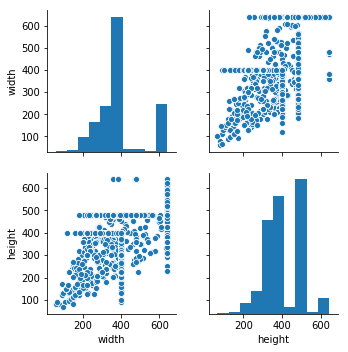

In [0]:
# sns.pairplot(first_photos_df[['width', 'height']]);

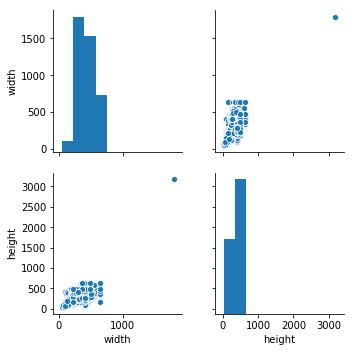

In [26]:
sns.pairplot(image_labels_full[['width', 'height']]);

In [0]:
# first_photos_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AdoptionSpeed,14652.0,2.502662,1.170092,0.0,2.0,2.0,4.0,4.0
width,14652.0,394.383429,125.547369,60.0,300.0,399.0,400.0,640.0
height,14652.0,397.546751,95.490883,67.0,300.0,400.0,480.0,640.0


In [27]:
image_labels_full.describe().T

,count,mean,std,min,25%,50%,75%,max
AdoptionSpeed,58311.0,2.491914,1.123897,0.0,2.0,2.0,3.0,4.0
width,58311.0,399.619437,125.797629,50.0,300.0,400.0,400.0,1792.0
height,58311.0,389.542831,94.202073,35.0,300.0,400.0,480.0,3184.0


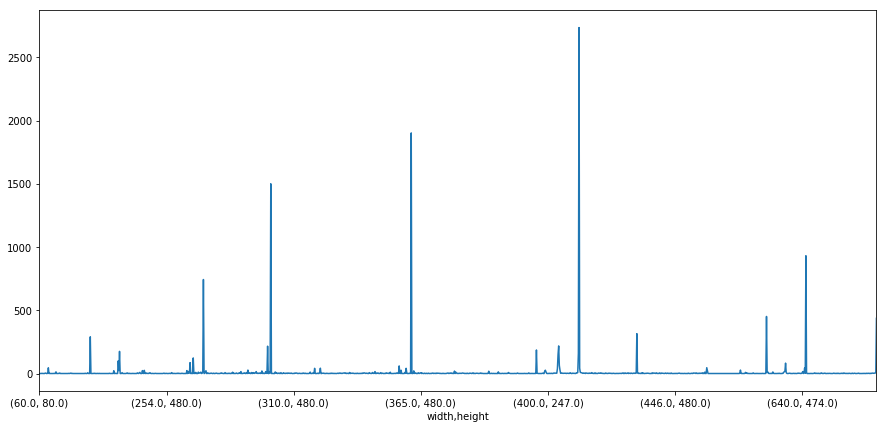

In [0]:
# fig, ax = plt.subplots(figsize=(15,7))
# first_photos_df.groupby(['width','height']).count()['AdoptionSpeed'].plot(ax=ax);

In [31]:
# small_images = first_photos_df[(first_photos_df.width < 100) & (first_photos_df.height < 100)]
# len(small_images)

small_images = image_labels_full[(image_labels_full.width <= 80) & (image_labels_full.height <= 80)]
len(small_images)

12

In [32]:
small_images.head()

,image,PetID,AdoptionSpeed,width,height
1737,data/pet/train_images/598f49a8f-5.jpg,598f49a8f,4,72.0,80.0
2269,data/pet/train_images/25fc96414-1.jpg,25fc96414,3,78.0,80.0
5315,data/pet/train_images/5bfbb098d-2.jpg,5bfbb098d,1,60.0,80.0
11099,data/pet/train_images/ec040a1ef-8.jpg,ec040a1ef,2,60.0,80.0
11593,data/pet/train_images/3cbe65e9a-3.jpg,3cbe65e9a,3,60.0,80.0


In [33]:
# small_mixed_images = first_photos_df[(first_photos_df.width < 100) | (first_photos_df.height < 100)]
small_mixed_images = image_labels_full[(image_labels_full.width < 100) | (image_labels_full.height < 100)]
len(small_mixed_images)

70

In [36]:
# large_images = first_photos_df[(first_photos_df.width > 600) | (first_photos_df.height > 600)]
large_images = image_labels_full[(image_labels_full.width > 1000) | (image_labels_full.height > 1000)]
len(large_images)

1

Very small images (widh and height less than 100 px)

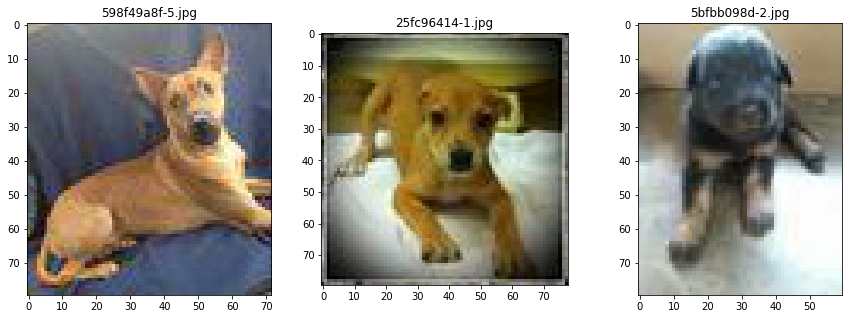

In [37]:
plot_df_images(small_images, 'image', 3, 1)

Small mixed images (width or height less than 100 px)

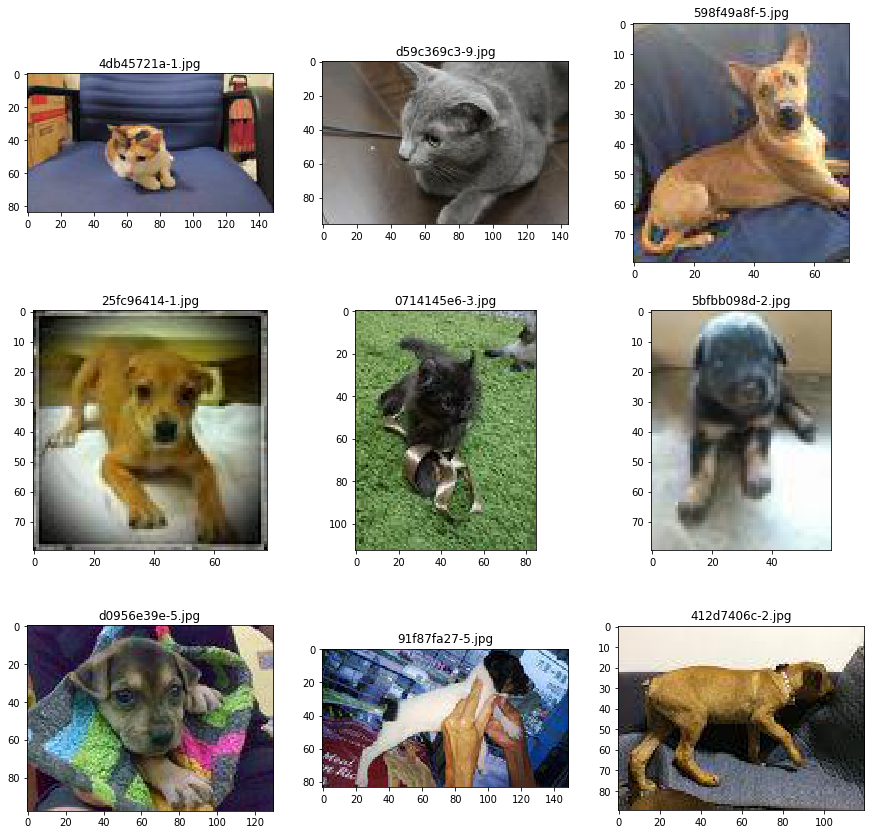

In [38]:
plot_df_images(small_mixed_images, 'image', 3, 3)

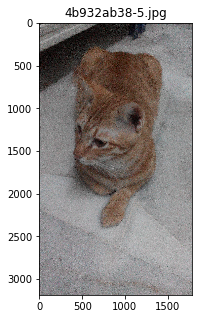

In [39]:
plot_df_images(large_images, 'image', 1, 1)

## Split dataset

In [84]:
# train_for_split, test_df = train_test_split(first_photos_df, random_state=42)
# train_df, val_df = train_test_split(train_for_split, random_state=42)
# print(f'train data: {len(train_df)}, validation data: {len(val_df)}, test data: {len(test_df)}')

train data: 8241, validation data: 2748, test data: 3663


In [40]:
train_for_split, test_df = train_test_split(image_labels_full, random_state=42)
train_df, val_df = train_test_split(train_for_split, random_state=42)
print(f'train data: {len(train_df)}, validation data: {len(val_df)}, test data: {len(test_df)}')

train data: 32799, validation data: 10934, test data: 14578


In [41]:
train_df.head()

,image,PetID,AdoptionSpeed,width,height
39083,data/pet/train_images/49113adb2-16.jpg,49113adb2,3,300.0,400.0
17053,data/pet/train_images/20a9ffb5c-10.jpg,20a9ffb5c,1,360.0,480.0
34419,data/pet/train_images/f21d7ec45-5.jpg,f21d7ec45,2,640.0,360.0
32155,data/pet/train_images/17be61e34-4.jpg,17be61e34,2,400.0,300.0
46707,data/pet/train_images/9d24c695e-2.jpg,9d24c695e,1,240.0,400.0


In [42]:
train_df.AdoptionSpeed.value_counts()

2    9277
3    8452
4    7859
1    6443
0     768
Name: AdoptionSpeed, dtype: int64

In [43]:
val_df.AdoptionSpeed.value_counts()

2    2980
3    2844
4    2620
1    2229
0     261
Name: AdoptionSpeed, dtype: int64

In [44]:
test_df.AdoptionSpeed.value_counts()

2    4181
3    3763
4    3455
1    2845
0     334
Name: AdoptionSpeed, dtype: int64

## Image augmentation

In [0]:
target_col = 'AdoptionSpeed'
image_path_col = 'image'
# img_dims = (128, 128)
# batch_size = 8
img_dims = (299, 299)
batch_size = 16

In [46]:
n_classes = train_df.AdoptionSpeed.nunique()
n_classes

5

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.55 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, img_dims)
    
    if flips in ['horizontal', 'both']:
        image = tf.image.random_flip_left_right(image)
    if flips in ['vertical', 'both']:
        image = tf.image.random_flip_up_down(image)
    
    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.clip_by_value(image, 0.0, 1.0)
        
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):  
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == 'stretch':
        image = tf.image.resize(image, img_dims)
    elif mode == 'crop':
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    else:
        raise ValueError("mode not implemented.")
        
    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    shuffle=False,
    prefetch=1,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    labels = df[y].values
    
    dataset_length = len(filenames)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=img_dims, mode=mode,
    )
    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)   
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    
#     if shuffle:
#         ds = ds.shuffle(dataset_length) # galima bandyti nurodyti batch_len
        
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    if prefetch:
        ds = ds.prefetch(prefetch)
        
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_df,
    x=image_path_col,
    y=target_col,
    batch_size=batch_size,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=3, flips='both'),
    mode='stretch',
    shuffle=False, 
    prefetch=1,
    num_parallel_calls=1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_df,
    x=image_path_col,
    y=target_col,
    batch_size=batch_size,
    parse_fn=image_parse,
    augment_fn=augment,
    mode='stretch',
    shuffle=False, 
    prefetch=1,
    num_parallel_calls=1,
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        print(x[0].shape)
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


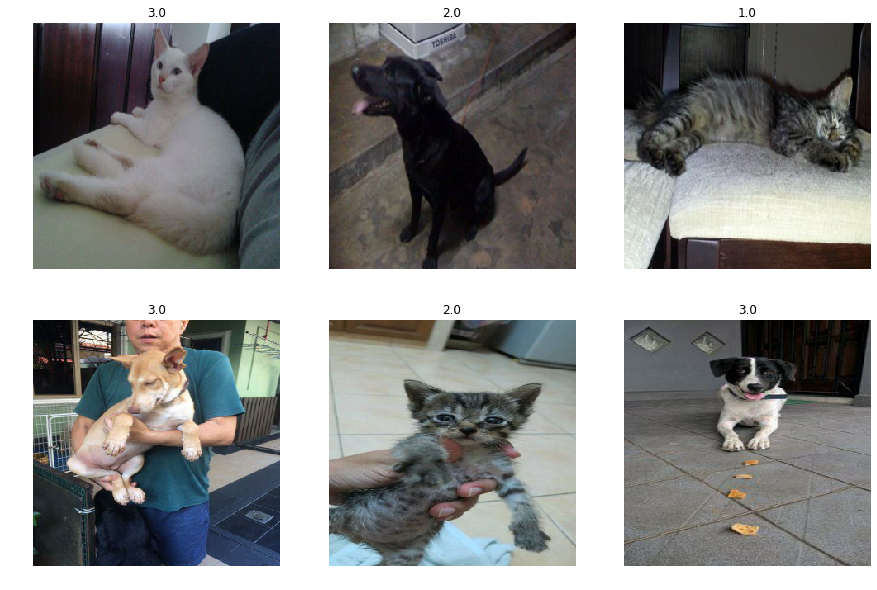

In [53]:
plot_dataset(val_dataset, 2, 3)

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


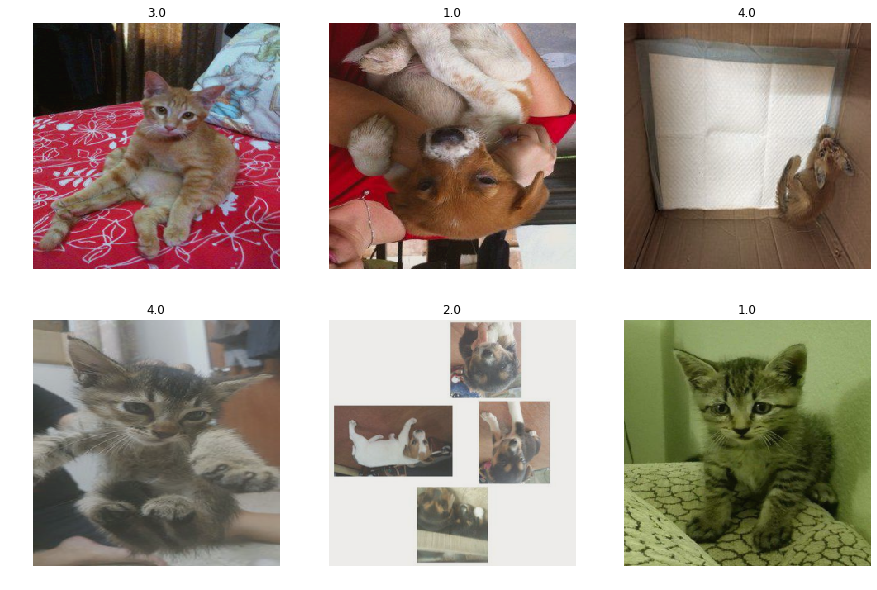

In [54]:
plot_dataset(train_dataset, 2, 3)

## Create NN model

In [0]:
def make_model(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.GlobalMaxPool2D()(base_model.output)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
save_path = TEMP_DIR + 'freezed_model_4.h5'

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    
    if easing_epochs:
        print('Start training with freezed layers:')
        for layer in model.layers[:-1]:
            layer.trainable = False
        
        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )
    
        easing_reduce_lr_patience = max(2, epochs // 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/train_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True)
            ],
            verbose=1,
        )
        
        print('Unfreeze layers:')
        for layer in model.layers[:-1]:
            layer.trainable = True
            
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/train_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ModelCheckpoint(save_path, save_best_only=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)
        ],
        verbose=1,
    )
    
    return history

In [58]:
model = make_model(
    n_classes=n_classes,
    input_shape=img_dims + (3,),
    dropout_rate=0.6,
    l1=3e-6,
    l2=3e-5,
)

83689472/83683744 [==============================] - 3s 0us/step


W0822 07:41:36.453892 139980986836864 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
# model.summary()

In [59]:
model_history = train_model(
    model=model, 
    optimizer=keras.optimizers.Adam,
    lr=3e-5,
    epochs=10,
    easing_epochs=4,
)

W0822 07:41:51.733268 139980986836864 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Start training with freezed layers:
Epoch 1/4


W0822 07:41:51.960911 139980986836864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2050/2050 [==============================] - 868s 423ms/step - loss: 3.4306 - sparse_categorical_accuracy: 0.2505 - val_loss: 1.7237 - val_sparse_categorical_accuracy: 0.2809
Epoch 2/4
2050/2050 [==============================] - 857s 418ms/step - loss: 3.1128 - sparse_categorical_accuracy: 0.2621 - val_loss: 1.6379 - val_sparse_categorical_accuracy: 0.2915
Epoch 3/4
2050/2050 [==============================] - 857s 418ms/step - loss: 2.8781 - sparse_categorical_accuracy: 0.2614 - val_loss: 1.5808 - val_sparse_categorical_accuracy: 0.2991
Epoch 4/4
2050/2050 [==============================] - 857s 418ms/step - loss: 2.7030 - sparse_categorical_accuracy: 0.2623 - val_loss: 1.5356 - val_sparse_categorical_accuracy: 0.3075


W0822 08:39:10.182099 139980986836864 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Unfreeze layers:
Epoch 1/10
2050/2050 [==============================] - 2849s 1s/step - loss: 1.4611 - sparse_categorical_accuracy: 0.3085 - val_loss: 1.3927 - val_sparse_categorical_accuracy: 0.3497
Epoch 2/10
2050/2050 [==============================] - 2815s 1s/step - loss: 1.3850 - sparse_categorical_accuracy: 0.3548 - val_loss: 1.3752 - val_sparse_categorical_accuracy: 0.3653
Epoch 3/10
2050/2050 [==============================] - 2819s 1s/step - loss: 1.3343 - sparse_categorical_accuracy: 0.3956 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.3685
Epoch 4/10
2050/2050 [==============================] - 2814s 1s/step - loss: 1.2610 - sparse_categorical_accuracy: 0.4436 - val_loss: 1.3849 - val_sparse_categorical_accuracy: 0.3765
Epoch 5/10
2050/2050 [==============================] - 2812s 1s/step - loss: 1.1615 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.4211 - val_sparse_categorical_accuracy: 0.3776
Epoch 6/10
2050/2050 [==============================] - 2811s 1

KeyboardInterrupt: ignored

In [0]:
# model_history.history.keys()

In [0]:
# plot_history(model_history, 'loss')

In [0]:
model_arch_path = TEMP_DIR + 'best_pet_image_model.json'
save_model_json(model_arch_path, model)

In [72]:
model = load_model_json(model_arch_path, save_path)

W0822 14:17:24.782247 139980986836864 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
    ],
)

Prepare test df for model evaluating

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    df=test_df,
    x=image_path_col,
    y=target_col,
    batch_size=batch_size,
    parse_fn=image_parse,
    augment_fn=augment,
    mode='stretch',
    shuffle=False, 
    prefetch=1,
    num_parallel_calls=1,
)

In [77]:
model.evaluate(test_dataset, steps=math.ceil(test_dataset_length/test_batch_size))

912/912 [==============================] - 280s 307ms/step - loss: 1.3648 - sparse_categorical_accuracy: 0.3727


[1.3647960036208755, 0.37268487]

In [0]:
test_predictions = model.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [80]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       334
         1.0       0.36      0.35      0.35      2845
         2.0       0.34      0.44      0.39      4181
         3.0       0.34      0.26      0.30      3763
         4.0       0.44      0.47      0.46      3455

    accuracy                           0.37     14578
   macro avg       0.30      0.30      0.30     14578
weighted avg       0.36      0.37      0.36     14578



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Visualize filters

In [81]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 255
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def visualize_one_filter(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = tf.reduce_mean(layer_output[:, :, :, filter_index])

    grads = tf.gradients(loss, model.input)[0]
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)

    iterate = tf.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

In [87]:
plt.imshow(visualize_one_filter(model, 'block1_conv1', 0))

RuntimeError: ignored

In [0]:
# %xmode

In [0]:
# plt.imshow(visualise_one_filter(model, 'block1_conv1', 0))

## Train only on one type of pets 

Try to train model on dogs only.

Add Type to dataframe - Type of animal (1 = Dog, 2 = Cat)

In [0]:
image_labels_w_types = image_labels_full.merge(train[['PetID', 'Type']], how='left', on='PetID')

In [26]:
image_labels_w_types.head()

,image,PetID,AdoptionSpeed,Type
0,data/pet/train_images/41e824cbe-13.jpg,41e824cbe,4,1
1,data/pet/train_images/e911008b8-2.jpg,e911008b8,1,1
2,data/pet/train_images/99459c30d-3.jpg,99459c30d,1,1
3,data/pet/train_images/2a154e41c-3.jpg,2a154e41c,2,1
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1,1


In [27]:
dog_df = image_labels_w_types[image_labels_w_types.Type == 1]
len(dog_df)

30341

In [29]:
dog_df.tail()

,image,PetID,AdoptionSpeed,Type
58306,data/pet/train_images/c6de9b701-6.jpg,c6de9b701,4,1
58307,data/pet/train_images/b7d23de06-3.jpg,b7d23de06,2,1
58308,data/pet/train_images/181fb7dae-2.jpg,181fb7dae,2,1
58309,data/pet/train_images/ba030cdba-1.jpg,ba030cdba,4,1
58310,data/pet/train_images/85327438d-4.jpg,85327438d,4,1


In [31]:
dogs_1_df = dog_df[dog_df.image.str.endswith('-1.jpg')]
len(dogs_1_df)

7938

In [32]:
dogs_1_df.head()

,image,PetID,AdoptionSpeed,Type
4,data/pet/train_images/52e555a3a-1.jpg,52e555a3a,1,1
18,data/pet/train_images/2f3ff5116-1.jpg,2f3ff5116,2,1
21,data/pet/train_images/bec55c577-1.jpg,bec55c577,4,1
24,data/pet/train_images/c0bc43dd6-1.jpg,c0bc43dd6,4,1
46,data/pet/train_images/fe4b30cfb-1.jpg,fe4b30cfb,1,1


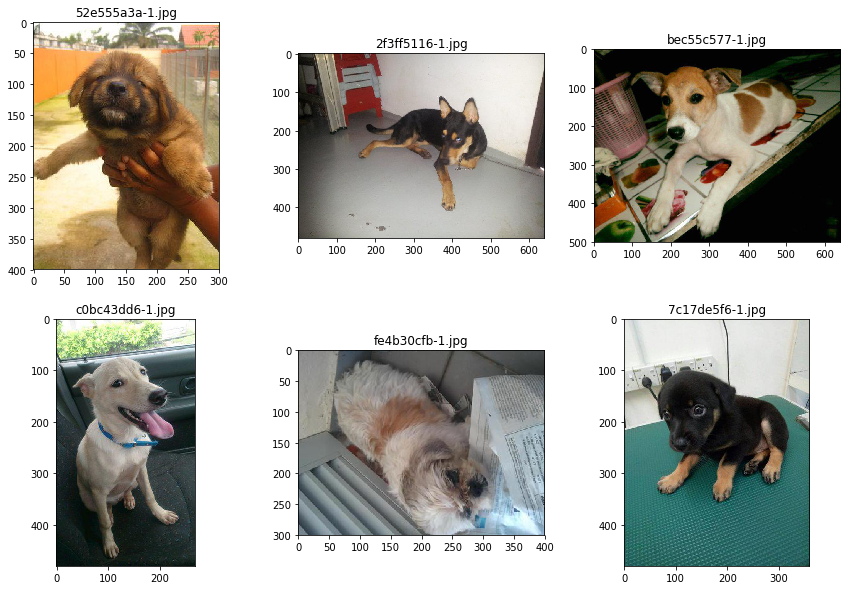

In [33]:
plot_df_images(dogs_1_df, 'image', 3, 2)

In [34]:
train_for_split_dogs, test_dogs_df = train_test_split(dogs_1_df)
train_dogs_df, val_dogs_df = train_test_split(train_for_split_dogs)
print(f'train data: {len(train_dogs_df)}, validation data: {len(val_dogs_df)}, test data: {len(test_dogs_df)}')

train data: 4464, validation data: 1489, test data: 1985


In [0]:
batch_size

In [38]:
n_classes = train_dogs_df.AdoptionSpeed.nunique()
n_classes

5

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_dogs_df,
    x=image_path_col,
    y=target_col,
    batch_size=batch_size,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=3, flips='both'),
    mode='stretch',
    shuffle=True, 
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_dogs_df,
    x=image_path_col,
    y=target_col,
    batch_size=batch_size,
    parse_fn=image_parse,
    augment_fn=augment,
    mode='stretch',
    shuffle=False, 
    prefetch=1,
    num_parallel_calls=-1,
)

In [47]:
dogs_model = make_model(
    n_classes=n_classes,
    input_shape=img_dims + (3,),
    dropout_rate=0.6,
    l1=3e-6,
    l2=3e-5,
)

83689472/83683744 [==============================] - 4s 0us/step


In [0]:
save_path = TEMP_DIR + 'freezed_dog_model_2.h5'

In [52]:
dogs_model_history = train_model(
    model=dogs_model, 
    optimizer=keras.optimizers.Adam,
    lr=1e-5,
    epochs=10,
    easing_epochs=5,
)

Start training with freezed layers:
Epoch 1/5
279/279 [==============================] - 51s 183ms/step - loss: 1.6691 - sparse_categorical_accuracy: 0.2437 - val_loss: 2.0557 - val_sparse_categorical_accuracy: 0.2827
Epoch 2/5
279/279 [==============================] - 34s 122ms/step - loss: 1.6291 - sparse_categorical_accuracy: 0.2565 - val_loss: 2.0232 - val_sparse_categorical_accuracy: 0.2868
Epoch 3/5
279/279 [==============================] - 38s 137ms/step - loss: 1.6137 - sparse_categorical_accuracy: 0.2628 - val_loss: 2.0050 - val_sparse_categorical_accuracy: 0.2928
Epoch 4/5
279/279 [==============================] - 38s 137ms/step - loss: 1.6133 - sparse_categorical_accuracy: 0.2574 - val_loss: 2.0021 - val_sparse_categorical_accuracy: 0.2881
Epoch 5/5
279/279 [==============================] - 38s 137ms/step - loss: 1.6146 - sparse_categorical_accuracy: 0.2677 - val_loss: 1.9796 - val_sparse_categorical_accuracy: 0.2834
Unfreeze layers:
Epoch 1/20
279/279 [=================

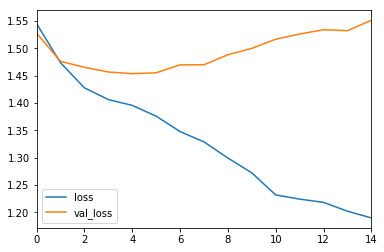

In [55]:
plot_history(model_history, 'loss')

## Train with different architecture - Resnet

In [0]:
save_path = TEMP_DIR + 'freezed_dog_model_resnet50.h5'

In [0]:
def make_model_2(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.ResNet50(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
#     x = keras.layers.GlobalMaxPool2D()(base_model.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [62]:
resnet_model = make_model_2(
    n_classes=n_classes,
    input_shape=img_dims + (3,),
    dropout_rate=0.8,
    l1=3e-6,
    l2=3e-5,
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [63]:
resnet_model_history = train_model(
    model=resnet_model, 
    optimizer=keras.optimizers.Adam,
    lr=1e-5,
    epochs=10,
    easing_epochs=3,
)

Start training with freezed layers:
Epoch 1/5
279/279 [==============================] - 54s 194ms/step - loss: 5.1965 - sparse_categorical_accuracy: 0.2316 - val_loss: 1.6494 - val_sparse_categorical_accuracy: 0.1927
Epoch 2/5
279/279 [==============================] - 32s 114ms/step - loss: 4.9713 - sparse_categorical_accuracy: 0.2453 - val_loss: 1.6374 - val_sparse_categorical_accuracy: 0.1927
Epoch 3/5
279/279 [==============================] - 38s 136ms/step - loss: 4.8677 - sparse_categorical_accuracy: 0.2352 - val_loss: 1.6338 - val_sparse_categorical_accuracy: 0.1927
Epoch 4/5
279/279 [==============================] - 38s 135ms/step - loss: 4.7631 - sparse_categorical_accuracy: 0.2556 - val_loss: 1.6309 - val_sparse_categorical_accuracy: 0.1927
Epoch 5/5
279/279 [==============================] - 38s 135ms/step - loss: 4.6593 - sparse_categorical_accuracy: 0.2596 - val_loss: 1.6254 - val_sparse_categorical_accuracy: 0.1927
Unfreeze layers:
Epoch 1/20
279/279 [=================

KeyboardInterrupt: ignored